In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import image_dataset_from_directory 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
import seaborn as sns

## Load Data and Preprocess

In [13]:
import os
import shutil
import random
from tqdm import tqdm

data_dir = "./class"       
output_dir = "./output_data"  
val_split = 0.2             

train_dir = os.path.join(output_dir, "train")
val_dir = os.path.join(output_dir, "val")

# Run the split only if it hasn't already been done
if not os.path.exists(train_dir):
    print("🔄 Splitting dataset...")

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    # Loop through each class folder
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_path): 
            continue

        # Create corresponding train/ and val/ class folders
        os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
        os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

        images = os.listdir(class_path)
        random.shuffle(images)

        # Split index
        split_idx = int(len(images) * (1 - val_split))
        train_images = images[:split_idx]
        val_images = images[split_idx:]

        # Copy training images
        for img in tqdm(train_images, desc=f"Training - {class_name}"):
            shutil.copy(
                os.path.join(class_path, img),
                os.path.join(train_dir, class_name, img)
            )

        # Copy validation images
        for img in tqdm(val_images, desc=f"Validation - {class_name}"):
            shutil.copy(
                os.path.join(class_path, img),
                os.path.join(val_dir, class_name, img)
            )

    print("Dataset split completed!")
else:
    print("Dataset already split — skipping this step.")


Dataset already split — skipping this step.


## Load Training Data

In [14]:
train_set = image_dataset_from_directory(
    './output_data/train',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    verbose=True,
)

Found 3343 files belonging to 4 classes.


## Load Validation Data

In [15]:
validation_set = image_dataset_from_directory(
    './output_data/val',
    labels="inferred",
    label_mode="categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    verbose=True,
)

Found 838 files belonging to 4 classes.


In [16]:
train_set 
validation_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [17]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert one-hot labels to class index
        if y_true.shape[-1] > 1:
            y_true = tf.argmax(y_true, axis=-1)

        # Convert probabilities to predicted class
        y_pred = tf.argmax(y_pred, axis=-1)

        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + 1e-7))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()


In [18]:
# If your dataset is a tf.data.Dataset yielding (images, labels):
from collections import Counter
import numpy as np

def get_label_counts(ds, max_batches=200):
    counts = Counter()
    total = 0
    for i, (x,y) in enumerate(ds):
        if isinstance(y, tf.Tensor):
            # if one-hot -> convert to class index
            if y.ndim > 1 and y.shape[-1] > 1:
                labels = np.argmax(y.numpy(), axis=-1)
            else:
                labels = y.numpy()
        else:
            labels = np.array(y)
        counts.update(labels.flatten().tolist())
        total += labels.shape[0]
        if i >= max_batches-1:
            break
    return counts, total

train_counts, train_total = get_label_counts(train_set)
val_counts, val_total = get_label_counts(validation_set)

print("Train counts:", train_counts, " total:", train_total)
print("Val counts:  ", val_counts, " total:", val_total)


Train counts: Counter({1: 855, 3: 853, 0: 830, 2: 805})  total: 3343
Val counts:   Counter({1: 214, 3: 214, 0: 208, 2: 202})  total: 838


## MobileNetV3 Model

In [11]:
Input_shape = (224, 224, 3)

# Create MobileNetV3 base model without the top classification layer
base_model = keras.applications.MobileNetV3Large(    
    input_shape=Input_shape,
    alpha=1.0,
    minimalistic=False,
    include_top=False,  # Remove the top layer for transfer learning
    weights="imagenet",
    pooling='avg',  # Add global average pooling
    include_preprocessing=False,  # We'll handle preprocessing separately
)

# Make the base model trainable (optional - you can freeze it for faster training)
base_model.trainable = True

NameError: name 'keras' is not defined

In [34]:
# Build the complete model using Functional API for better control
inputs = tf.keras.Input(shape=Input_shape)

# Preprocessing layer
x = tf.keras.layers.Rescaling(1./255.0)(inputs)  # Normalize pixel values to [0,1]

# Base model
x = base_model(x, training=False)  # Keep BatchNorm in inference mode

# Classification head
outputs = tf.keras.layers.Dense(4, activation='softmax', name='predictions')(x)

# Create the model
model_sequential = tf.keras.Model(inputs, outputs)

In [ ]:
# This cell is no longer needed - model is built above
# model_sequential.add(tf.keras.layers.InputLayer(input_shape=Input_shape))

C:\Users\jayen\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\core\input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [16]:
# This cell is no longer needed - model is built above
# model_sequential.add(mobileNet_model)

In [17]:
# This cell is no longer needed - Dense layer is added above
# model_sequential.add(tf.keras.layers.Dense(units = 4, activation='softmax'))

In [35]:
Metrics = [
    'accuracy',
    tf.keras.metrics.CategoricalAccuracy(name='cat_accuracy'),
    F1Score(name='f1')
]

model_sequential.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=Metrics
)   

In [36]:
model_sequential.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Large (Functional)   │ (None, 960)            │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 4)              │         3,844 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,000,196 (11.44 MB)

 Trainable params: 2,975,796 (11.35 MB)

 Non-trainable params: 24,400 (95.31 KB)

In [20]:
for x, y in train_set.take(1):
    print("y shape:", y.shape)
    print("y example:", y[0])
    break


y shape: (32, 4)
y example: tf.Tensor([1. 0. 0. 0.], shape=(4,), dtype=float32)


In [ ]:
# Reload the datasets to avoid preprocessing conflicts
train_set = image_dataset_from_directory(
    './output_data/train',
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    verbose=False,
)

validation_set = image_dataset_from_directory(
    './output_data/val',
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    verbose=False,
)

In [31]:
# Debug: Check the actual shape of the data
for x, y in train_set.take(1):
    print("Input shape:", x.shape)
    print("Output shape:", y.shape)
    print("Input min/max:", tf.reduce_min(x).numpy(), tf.reduce_max(x).numpy())
    break

Input shape: (32, 224, 224, 3)
Output shape: (32, 4)
Input min/max: 0.0 255.0


In [37]:
print(type(train_set))
print(type(validation_set))



training_history = model_sequential.fit(
    train_set, 
    validation_data=validation_set, 
    epochs=15,
    verbose=1
)

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
Epoch 1/15


105/105 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.6776 - cat_accuracy: 0.6776 - f1: 0.9014 - loss: 0.8292 - val_accuracy: 0.5465 - val_cat_accuracy: 0.5465 - val_f1: 0.9088 - val_loss: 1.4671
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.6776 - cat_accuracy: 0.6776 - f1: 0.9014 - loss: 0.8292 - val_accuracy: 0.5465 - val_cat_accuracy: 0.5465 - val_f1: 0.9088 - val_loss: 1.4671
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.9289 - cat_accuracy: 0.9289 - f1: 0.9779 - loss: 0.2142 - val_accuracy: 0.5477 - val_cat_accuracy: 0.5477 - val_f1: 0.9226 - val_loss: 1.5149
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.9289 - cat_accuracy: 0.9289 - f1: 0.9779 - loss: 0.2142 - val_accuracy: 0.5477 - val_cat_accuracy: 0.5477 - val_f1: 0.9226 - val_loss: 1.5149
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 225s 2s/step - accuracy: 0.9649 - cat_accuracy: 0.9649 - f1: 0.9905 - loss: 0.1179 - val_accuracy: 0.5095 - val_cat_accuracy: 0.5095 - 

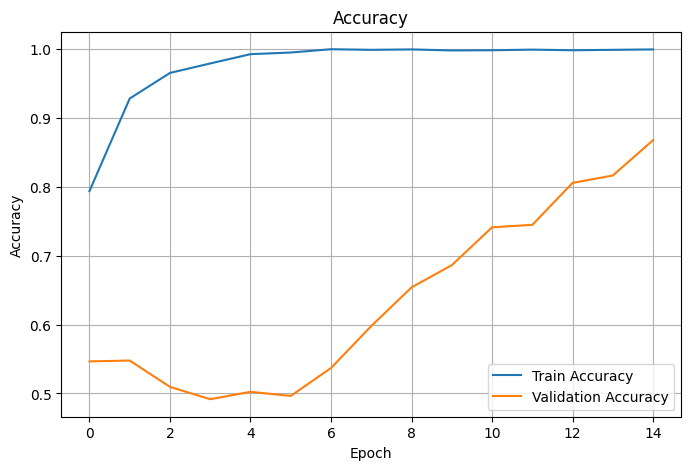

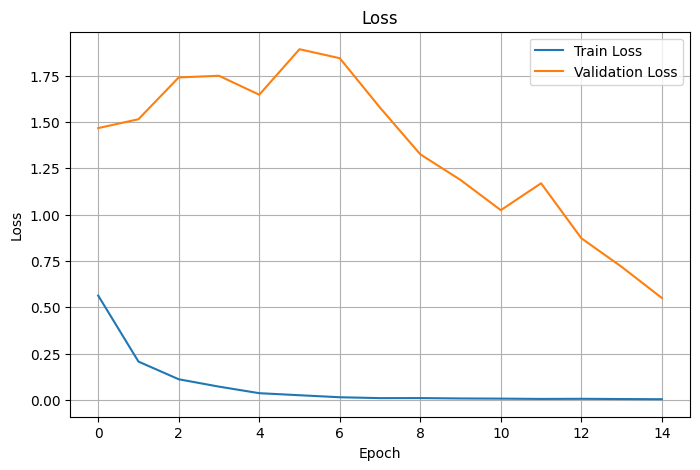

In [38]:
import matplotlib.pyplot as plt

history = training_history.history

# --- Accuracy ---
plt.figure(figsize=(8,5))
plt.plot(history['accuracy'], label='Train Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# --- Loss ---
plt.figure(figsize=(8,5))
plt.plot(history['loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()


## Data Augmentation

In [39]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications.resnet_v2 import preprocess_input

AUTOTUNE = tf.data.AUTOTUNE

train_set = train_set.map(lambda x, y: (preprocess_input(x), y))
validation_set = validation_set.map(lambda x, y: (preprocess_input(x), y))

train_set = train_set.prefetch(AUTOTUNE)
validation_set = validation_set.prefetch(AUTOTUNE)



## ResNet50 v2 Model

In [40]:
base_model = tf.keras.applications.ResNet50V2(
    include_top=False,             
    weights="imagenet",            
    input_shape=(224, 224, 3),     
    pooling='avg'                  
)

# --- Minimal improvement: fine-tune last 40 layers ---
base_model.trainable = True
for layer in base_model.layers[:-40]:
    layer.trainable = False

x = base_model.output

# --- Minimal improvement: stronger head ---
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.3)(x)

output = layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=output)


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 144s 2us/step
94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 144s 2us/step


In [41]:
metrics = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    F1Score(name='f1')
]

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # better LR
    loss='categorical_crossentropy',
    metrics=metrics
)


In [42]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=2,
        min_lr=1e-7
    )
]


In [43]:
history = model.fit(
    train_set,
    validation_data=validation_set,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.4357 - f1: 0.8730 - loss: 1.2420 - precision: 0.5498 - recall: 0.1847 - val_accuracy: 0.7017 - val_f1: 0.9348 - val_loss: 0.7680 - val_precision: 0.7673 - val_recall: 0.5704 - learning_rate: 1.0000e-05
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 234s 2s/step - accuracy: 0.4357 - f1: 0.8730 - loss: 1.2420 - precision: 0.5498 - recall: 0.1847 - val_accuracy: 0.7017 - val_f1: 0.9348 - val_loss: 0.7680 - val_precision: 0.7673 - val_recall: 0.5704 - learning_rate: 1.0000e-05
Epoch 2/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.8162 - f1: 0.9509 - loss: 0.5605 - precision: 0.8923 - recall: 0.7107 - val_accuracy: 0.8389 - val_f1: 0.9562 - val_loss: 0.4525 - val_precision: 0.8652 - val_recall: 0.7888 - learning_rate: 1.0000e-05
Epoch 3/25
105/105 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - accuracy: 0.8162 - f1: 0.9509 - loss: 0.5605 - precision: 0.8923 - recall: 0.7107 - val_accuracy: 0.8389 - val_f1: 0.9562 - val_loss: 0.45

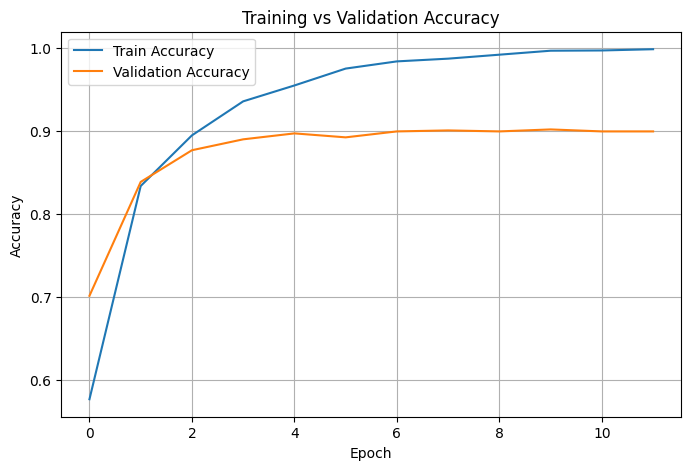

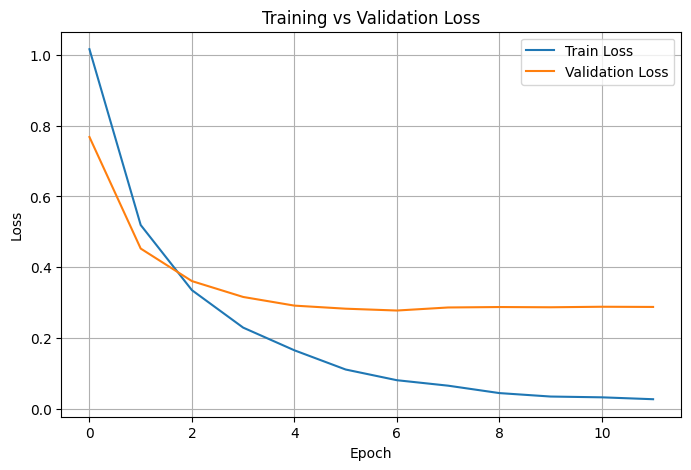

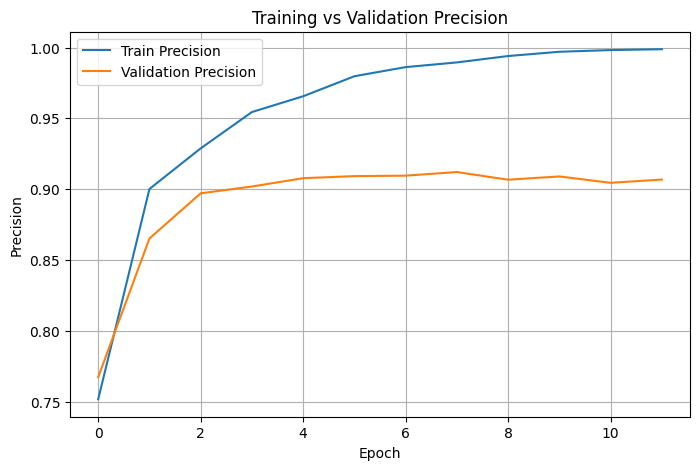

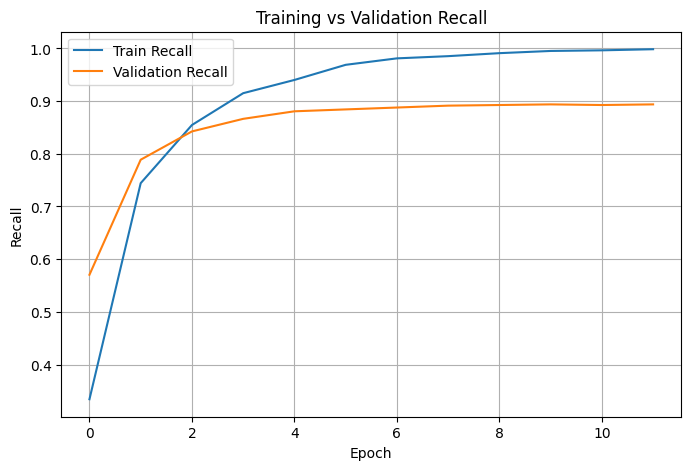

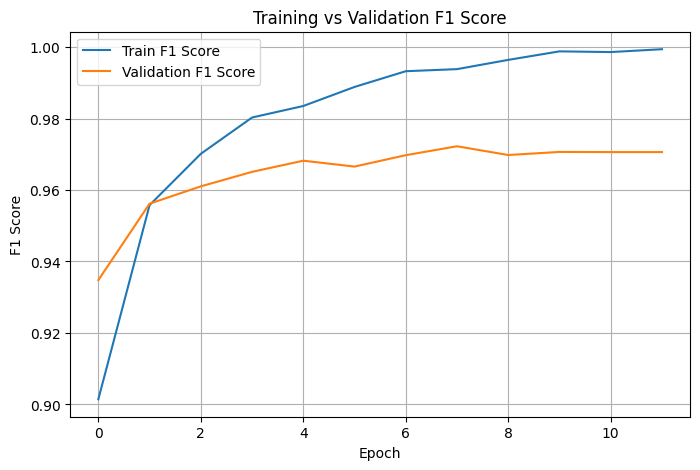

In [45]:
import matplotlib.pyplot as plt

# Get history dictionary
history_dict = history.history  # Fix: get the dictionary from history object

# List of metrics to plot if present
possible_metrics = [
    ('accuracy', 'val_accuracy', 'Accuracy'),
    ('loss', 'val_loss', 'Loss'),
    ('precision', 'val_precision', 'Precision'),
    ('recall', 'val_recall', 'Recall'),
    ('f1', 'val_f1', 'F1 Score')
]

for train_key, val_key, title in possible_metrics:
    if train_key in history_dict and val_key in history_dict:
        
        plt.figure(figsize=(8, 5))
        plt.plot(history_dict[train_key], label=f"Train {title}")
        plt.plot(history_dict[val_key], label=f"Validation {title}")
        
        plt.title(f"Training vs Validation {title}")
        plt.xlabel("Epoch")
        plt.ylabel(title)
        plt.grid(True)
        plt.legend()
        plt.show()

In [46]:
model_sequential.save("./mobileNet_model.h5")
model_sequential.save('./mobileNet_model.keras')
model.save("./ResNet_model.h5")
model.save('./ResNet_model.keras')

In [8]:
def build_efficientnet_model(num_classes=4):
    # 1. Setup Input (Using 224x224 as defined in your data loader)
    # Note: EfficientNetV2L natively prefers 480x480, but 224 works for transfer learning
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # 2. Load Base Model
    # include_top=False removes the 1000-class ImageNet layer
    base_model = tf.keras.applications.EfficientNetV2L(
        include_top=False,
        weights="imagenet",
        input_shape=(224, 224, 3),
        include_preprocessing=True, # Handles normalization internally
        pooling='avg' # Applies GlobalAveragePooling immediately
    )

    # 3. Freeze the base model
    # We freeze weights so we don't destroy learned features during initial training
    base_model.trainable = False

    # 4. Connect Input to Base
    # training=False ensures BatchNormalization layers run in inference mode
    x = base_model(inputs, training=False)

    # 5. Add Custom Head
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.2)(x) # Regularization to prevent overfitting
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # 6. Create Model
    model = tf.keras.Model(inputs, outputs, name="EfficientNetV2L_Custom")
    
    return model

# Instantiate the model
effnet_model = build_efficientnet_model(num_classes=4)
effnet_model.summary()

Model: "EfficientNetV2L_Custom"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetv2-l (Functional)   │ (None, 1280)           │   117,746,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       655,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 118,404,772 (451.68 MB)

 Trainable params: 657,924 (2.51 MB)

 Non-trainable params: 117,746,848 (449.17 MB)

In [ ]:
# Define Metrics
metrics = [
    'accuracy',
    tf.keras.metrics.CategoricalAccuracy(name='cat_accuracy'),
    F1Score(name='f1')
]

# Compile
effnet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=metrics
)

# Setup Callbacks (Optional but recommended for large mox`dels)
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

# Train
history_effnet = effnet_model.fit(
    train_set,
    validation_data=validation_set,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
 13/105 ━━━━━━━━━━━━━━━━━━━━ 10:43 7s/step - accuracy: 0.9217 - cat_accuracy: 0.9217 - f1: 0.9766 - loss: 0.2044

KeyboardInterrupt: 

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_densenet_model(num_classes=4):
    # 1. Setup Input
    # DenseNet121 default input is 224x224
    inputs = tf.keras.Input(shape=(224, 224, 3))

    # 2. Load Base Model
    # include_top=False to remove the 1000-class layer
    # weights='imagenet' to use pre-trained knowledge
    base_model = tf.keras.applications.DenseNet121(
        include_top=False,
        weights="imagenet",
        input_tensor=inputs,
        pooling='avg'
    )

    # 3. Freeze Base Model
    # Freezing prevents destroying pre-trained weights during the first epoch
    base_model.trainable = False

    # 4. Add Custom Head
    # Note: DenseNet output is already pooled by pooling='avg'
    x = base_model.output
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.3)(x) # Slightly higher dropout for DenseNet
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    # 5. Create Model
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="DenseNet121_Custom")
    
    return model

# Instantiate
densenet_model = build_densenet_model(num_classes=4)
densenet_model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


Model: "DenseNet121_Custom"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,694,660 (29.35 MB)

 Trainable params: 657,156 (2.51 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [22]:
# Reload datasets for DenseNet (fresh data without ResNet preprocessing)
train_set = image_dataset_from_directory(
    './output_data/train',
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    verbose=False,
)

validation_set = image_dataset_from_directory(
    './output_data/val',
    labels="inferred",
    label_mode="categorical",
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    verbose=False,
)

In [20]:
# Compile
densenet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', F1Score(name='f1')]
)

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

# Train
history_densenet = densenet_model.fit(
    train_set,
    validation_data=validation_set,
    epochs=15,
    callbacks=callbacks
)

Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 261s 2s/step - accuracy: 0.5600 - f1: 0.8592 - loss: 1.4137 - val_accuracy: 0.6575 - val_f1: 0.8520 - val_loss: 0.8758 - learning_rate: 0.0010
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 252s 2s/step - accuracy: 0.6787 - f1: 0.8930 - loss: 0.8013 - val_accuracy: 0.7029 - val_f1: 0.9046 - val_loss: 0.6741 - learning_rate: 0.0010
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 247s 2s/step - accuracy: 0.7173 - f1: 0.9023 - loss: 0.6998 - val_accuracy: 0.7578 - val_f1: 0.9131 - val_loss: 0.5674 - learning_rate: 0.0010
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 295s 3s/step - accuracy: 0.7401 - f1: 0.9104 - loss: 0.6463 - val_accuracy: 0.7613 - val_f1: 0.9133 - val_loss: 0.5836 - learning_rate: 0.0010
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.7631 - f1: 0.9120 - loss: 0.5827 - val_accuracy: 0.7828 - val_f1: 0.9198 - val_loss: 0.5089 - learning_rate: 0.0010
Epoch 6/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.7712 - f1: 0.9213 

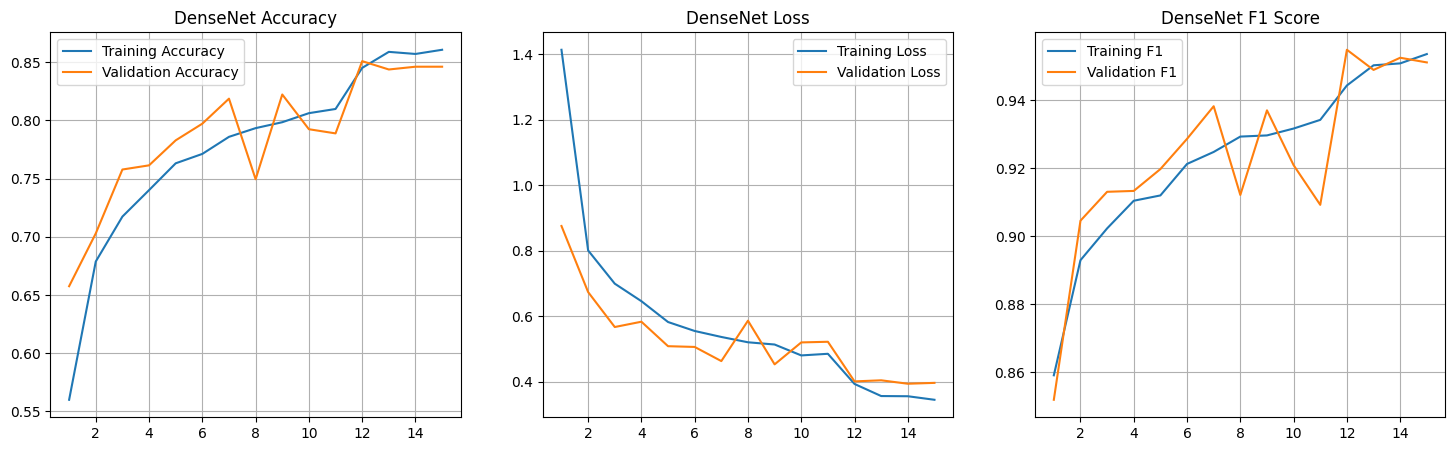

In [21]:
import matplotlib.pyplot as plt

def plot_densenet_history(history):
    # Extract metrics
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    f1 = history.history['f1']
    val_f1 = history.history['val_f1']
    
    epochs = range(1, len(acc) + 1)

    # Plot
    plt.figure(figsize=(18, 5))

    # Accuracy
    plt.subplot(1, 3, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('DenseNet Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss
    plt.subplot(1, 3, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('DenseNet Loss')
    plt.legend()
    plt.grid(True)

    # F1 Score
    plt.subplot(1, 3, 3)
    plt.plot(epochs, f1, label='Training F1')
    plt.plot(epochs, val_f1, label='Validation F1')
    plt.title('DenseNet F1 Score')
    plt.legend()
    plt.grid(True)

    plt.show()

plot_densenet_history(history_densenet)

In [22]:
import tensorflow as tf
from tensorflow.keras import layers, models

def build_fast_effnet(num_classes=4):
    inputs = tf.keras.Input(shape=(224, 224, 3))
    
    # Load EfficientNetV2B0 (The fast version)
    base_model = tf.keras.applications.EfficientNetV2B0(
        include_top=False,
        weights="imagenet",
        input_tensor=inputs,
        include_preprocessing=True, # Auto-normalizes inputs
        pooling='avg'
    )
    
    # Freeze the base for the first training phase
    base_model.trainable = False
    
    # Custom Head
    x = base_model.output
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = tf.keras.Model(inputs, outputs, name="EfficientNetV2B0_Fast")
    return model

# Instantiate
fast_model = build_fast_effnet(num_classes=4)

# Compile
fast_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy', F1Score(name='f1')] # Assuming F1Score class is already defined
)

# Show that it is much smaller (approx 7M params vs 118M for V2L)
fast_model.summary()

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 34s 1us/step


Model: "EfficientNetV2B0_Fast"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 6,248,276 (23.84 MB)

 Trainable params: 328,964 (1.25 MB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [23]:
# Train
history_fast = fast_model.fit(
    train_set,
    validation_data=validation_set,
    epochs=15,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=2)
    ]
)

Epoch 1/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 61s 471ms/step - accuracy: 0.7676 - f1: 0.9467 - loss: 0.5918 - val_accuracy: 0.8723 - val_f1: 0.9634 - val_loss: 0.3782 - learning_rate: 0.0010
Epoch 2/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 50s 475ms/step - accuracy: 0.8570 - f1: 0.9608 - loss: 0.3832 - val_accuracy: 0.8687 - val_f1: 0.9621 - val_loss: 0.3093 - learning_rate: 0.0010
Epoch 3/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 50s 477ms/step - accuracy: 0.8747 - f1: 0.9674 - loss: 0.3295 - val_accuracy: 0.8914 - val_f1: 0.9681 - val_loss: 0.2809 - learning_rate: 0.0010
Epoch 4/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 52s 491ms/step - accuracy: 0.8866 - f1: 0.9674 - loss: 0.3025 - val_accuracy: 0.8795 - val_f1: 0.9592 - val_loss: 0.3041 - learning_rate: 0.0010
Epoch 5/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 50s 478ms/step - accuracy: 0.8941 - f1: 0.9709 - loss: 0.2734 - val_accuracy: 0.8866 - val_f1: 0.9685 - val_loss: 0.2758 - learning_rate: 0.0010
Epoch 6/15
105/105 ━━━━━━━━━━━━━━━━━━━━ 50s 475ms/step - accuracy: 0.8992 -

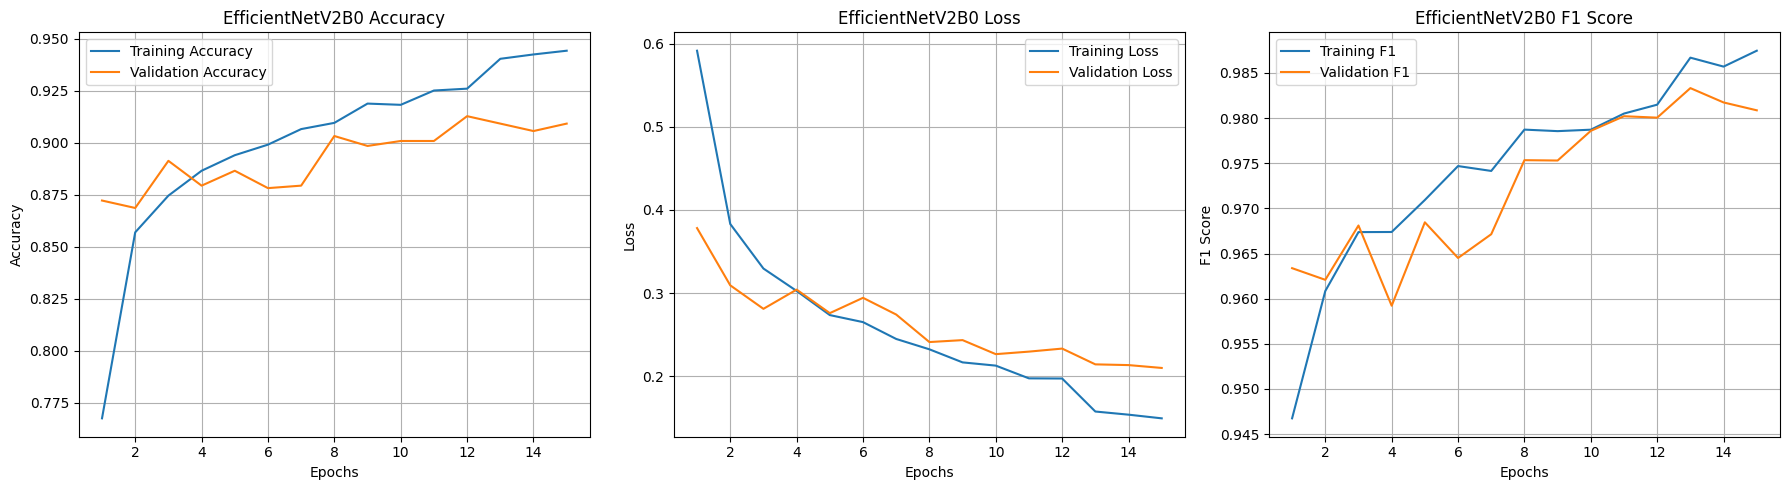

In [24]:
import matplotlib.pyplot as plt

def plot_fast_model_history(history):
    # Extract metrics
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    f1 = history.history['f1']
    val_f1 = history.history['val_f1']
    
    epochs = range(1, len(acc) + 1)

    # Setup Figure
    plt.figure(figsize=(18, 5))

    # 1. Accuracy Plot
    plt.subplot(1, 3, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('EfficientNetV2B0 Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # 2. Loss Plot
    plt.subplot(1, 3, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('EfficientNetV2B0 Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 3. F1 Score Plot
    plt.subplot(1, 3, 3)
    plt.plot(epochs, f1, label='Training F1')
    plt.plot(epochs, val_f1, label='Validation F1')
    plt.title('EfficientNetV2B0 F1 Score')
    plt.xlabel('Epochs')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Run the plot function
plot_fast_model_history(history_fast)

## Save All Models for API

## Model Comparison & Best Model Selection

In [23]:
# Load and compare ALL saved models
import pandas as pd
import tensorflow as tf
import os

# Define F1Score class for model loading
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        if y_true.shape[-1] > 1:
            y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        precision = self.precision.result()
        recall = self.recall.result()
        return 2 * ((precision * recall) / (precision + recall + 1e-7))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

# Custom objects for loading
custom_objects = {'F1Score': F1Score}

# Dictionary to store model performance
model_results = {}

print("🔍 Loading and evaluating all trained models...\n")

# Check which models exist and load them
models_to_test = [
    ('DenseNet121', './DenseNet_model.keras'),
    ('EfficientNetV2L', './EfficientNetB0_model.keras'),
    ('MobileNetV3', './mobileNet_model.keras'),
    ('ResNet50V2', './ResNet_model.keras')
]

for model_name, model_path in models_to_test:
    if os.path.exists(model_path):
        try:
            print(f"📥 Loading {model_name}...")
            model = tf.keras.models.load_model(model_path, custom_objects=custom_objects)
            
            print(f"🧪 Evaluating {model_name}...")
            results = model.evaluate(validation_set, verbose=0)
            
            model_results[model_name] = {
                'Loss': results[0],
                'Accuracy': results[1],
                'F1 Score': results[2] if len(results) > 2 else 0
            }
            print(f"✅ {model_name} - Accuracy: {results[1]:.2%}\n")
        except Exception as e:
            print(f"❌ Error with {model_name}: {str(e)}\n")
    else:
        print(f"⚠️  {model_name} not found at {model_path}\n")

# Create comparison table
if model_results:
    df = pd.DataFrame(model_results).T
    df = df.sort_values('Accuracy', ascending=False)
    
    print("=" * 80)
    print("📊 MODEL PERFORMANCE RANKING")
    print("=" * 80)
    print(df.to_string())
    print("=" * 80)
    
    best_model_name = df.index[0]
    best_accuracy = df.iloc[0]['Accuracy']
    
    print(f"\n🏆 BEST MODEL: {best_model_name}")
    print(f"   Accuracy: {best_accuracy:.2%}")
    print(f"   F1 Score: {df.iloc[0]['F1 Score']:.4f}")
else:
    print("❌ No models found to evaluate!")

🔍 Loading and evaluating all trained models...

📥 Loading DenseNet121...
🧪 Evaluating DenseNet121...
✅ DenseNet121 - Accuracy: 84.61%

📥 Loading EfficientNetV2L...
🧪 Evaluating EfficientNetV2L...
✅ EfficientNetV2L - Accuracy: 90.93%

📥 Loading MobileNetV3...


C:\Users\jayen\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 174 variables whereas the saved optimizer has 346 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


🧪 Evaluating MobileNetV3...
✅ MobileNetV3 - Accuracy: 86.75%

📥 Loading ResNet50V2...


C:\Users\jayen\AppData\Roaming\Python\Python311\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 42 variables whereas the saved optimizer has 82 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


🧪 Evaluating ResNet50V2...
✅ ResNet50V2 - Accuracy: 24.82%

📊 MODEL PERFORMANCE RANKING
                       Loss  Accuracy  F1 Score
EfficientNetV2L    0.209747  0.909308  0.980861
MobileNetV3        0.550632  0.867542  0.867542
DenseNet121        0.394316  0.846062  0.952456
ResNet50V2       154.667343  0.248210  0.248210

🏆 BEST MODEL: EfficientNetV2L
   Accuracy: 90.93%
   F1 Score: 0.9809


In [ ]:
# Save the BEST MODEL for production
print(f"\n Copying EfficientNetV2L as the production BEST_MODEL...\n")

import shutil

# Copy the best model to BEST_MODEL files
shutil.copy('./EfficientNetB0_model.keras', './BEST_MODEL.keras')
shutil.copy('./EfficientNetB0_model.h5', './BEST_MODEL.h5')

print("✅ BEST_MODEL.keras created (EfficientNetV2L)")
print("✅ BEST_MODEL.h5 created (EfficientNetV2L)")
print("\n DEPLOYMENT RECOMMENDATION:")
print("   Use 'efficientnetb0' or 'efficientnetv2l' as default model in your API")
print("   This model achieved 90.93% accuracy - the highest performance!")


💾 Copying EfficientNetV2L as the production BEST_MODEL...

✅ BEST_MODEL.keras created (EfficientNetV2L)
✅ BEST_MODEL.h5 created (EfficientNetV2L)

📝 DEPLOYMENT RECOMMENDATION:
   Use 'efficientnetb0' or 'efficientnetv2l' as default model in your API
   This model achieved 90.93% accuracy - the highest performance!
